In [1]:
#imports
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
import pyarrow.parquet as pa
import contractions
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize

# Download the tokenizer (one-time setup)
nltk.download('punkt_tab')




[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
#Reading the dataset and displaying it
data = pd.read_parquet('train-00000-of-00001-a0f92f8fbc6b2308.parquet')
print(data.columns)
print(data.info())



Index(['text', 'language_code'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33883 entries, 0 to 33882
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           33883 non-null  object
 1   language_code  33883 non-null  object
dtypes: object(2)
memory usage: 529.6+ KB
None


In [3]:
#Changing the data from parquet to csv 
data.to_csv('dataset.csv', index=False)
data = pd.read_csv('dataset.csv')

In [4]:
"""
# Step 2: Define a cleaning function
def clean_text(text):
    if not isinstance(text, str):  # Handle missing or non-string values
        return ""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[0-9]', '', text)  # Remove all numeric digits
    text = re.sub(r'[^\w\s\']', '', text)  # Remove unwanted characters (keep words, spaces, and apostrophes)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()  # Remove leading and trailing whitespace

# Step 3: Apply cleaning to all relevant text columns
text_columns = ['text']  # Update this with the list of text columns to clean
for column in text_columns:
    data[f'{column}_cleaned'] = data[column].apply(clean_text)

# Step 4: Handle missing values (optional)
for column in text_columns:
    data.dropna(subset=[f'{column}_cleaned'], inplace=True)  # Drop rows where the cleaned text is missing

# Step 5: Save the cleaned data back to CSV
data.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

# Step 6: Preview the cleaned data
print(data.head())
"""

def clean_text(text):
    if isinstance(text, str):
     

        # Remove special characters and digits, but preserve all alphabetic characters
        
        text = re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑа-яА-ЯёЁ\u4e00-\u9fff\uac00-\ud7af\u3040-\u30ff\u3130-\u318f\s]', '', text)
        
        # Remove extra whitespace
        text = text.strip()
        # Expand contractions
        text = contractions.fix(text)
        
        return text
    else:
        return ""

# Step 2: Apply the cleaning function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Step 3: Remove NaN rows
data.dropna(subset=['cleaned_text'], inplace=True)

# Step 4: Tokenization (split the cleaned text into words)
def tokenize_text(text):
    return word_tokenize(text.lower())  # Tokenize and make lowercase for standardization

data['tokens'] = data['cleaned_text'].apply(tokenize_text)



<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Admin\AppData\Local\Temp\ipykernel_9528\3118051551.py:1: SyntaxWarning: invalid escape sequence '\w'
  """


In [5]:
# Step 5: Encode the 'language' column using LabelEncoder
label_encoder = LabelEncoder()
data['language_encoded'] = label_encoder.fit_transform(data['language_code'])

# Step 6: Print the mapping of original labels to numeric labels
print("Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Step 7: Print the DataFrame with language and encoded labels
print(data[['language_code', 'language_encoded']])

# Step 8: Optional - Inverse transformation: converting encoded values back to original labels
inverse_labels = label_encoder.inverse_transform(data['language_encoded'])
print("Inverse transformation result:", inverse_labels)

Mapping: {'de': 0, 'en': 1, 'es': 2, 'fr': 3, 'it': 4, 'nl': 5, 'pl': 6, 'pt': 7, 'ru': 8, 'zh-TW': 9}
      language_code  language_encoded
0                pt                 7
1                pl                 6
2                pt                 7
3                ru                 8
4                nl                 5
...             ...               ...
33878            nl                 5
33879            pt                 7
33880            it                 4
33881            it                 4
33882            it                 4

[33883 rows x 2 columns]
Inverse transformation result: ['pt' 'pl' 'pt' ... 'it' 'it' 'it']


In [6]:
data.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")
print(data.info())
print(data.columns)
data.head(n=15)

Cleaned dataset saved as 'cleaned_dataset.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33883 entries, 0 to 33882
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text              33883 non-null  object
 1   language_code     33883 non-null  object
 2   cleaned_text      33883 non-null  object
 3   tokens            33883 non-null  object
 4   language_encoded  33883 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 1.2+ MB
None
Index(['text', 'language_code', 'cleaned_text', 'tokens', 'language_encoded'], dtype='object')


,text,language_code,cleaned_text,tokens,language_encoded
0,Fluoretos binários de metalóides e não-metais ...,pt,Fluoretos binários de metalóides e nometais de...,"[fluoretos, binários, de, metalóides, e, nomet...",7
1,Policja w Birmie postawiła Aung San Suu Kyi dw...,pl,Policja w Birmie postawia Aung San Suu Kyi dwa...,"[policja, w, birmie, postawia, aung, san, suu,...",6
2,Ter sistemas de armas nucleares em alerta máxi...,pt,Ter sistemas de armas nucleares them alerta má...,"[ter, sistemas, de, armas, nucleares, them, al...",7
3,"Взрыв 74+19+16! Дюрэнт и Харден сошли с ума, о...",ru,Взрыв Дюрэнт и Харден сошли с ума оба установ...,"[взрыв, дюрэнт, и, харден, сошли, с, ума, оба,...",8
4,Ze had slechts één voorwaarde: dat het boek pa...,nl,Ze had slechts één voorwaarde dat het boek pas...,"[ze, had, slechts, één, voorwaarde, dat, het, ...",5
5,Narendra Modi belooft een harde houding tegeno...,nl,Narendra Modi belooft een harde houding tegeno...,"[narendra, modi, belooft, een, harde, houding,...",5
6,"Kang Young-hoon (,), South Korean Army Lieuten...",en,Kang Younghoon South Korean Army Lieutenant G...,"[kang, younghoon, south, korean, army, lieuten...",1
7,¿Por qué la deducción no tiene éxito? El saldo...,es,Por qué la deducción no tiene éxito El saldo e...,"[por, qué, la, deducción, no, tiene, éxito, el...",2
8,Kobieta trzyma w ramionach małego kangura.,pl,Kobieta trzyma w ramionach maego kangura,"[kobieta, trzyma, w, ramionach, maego, kangura]",6
9,O castelo foi remodelado duas vezes: primeiro ...,pt,O castelo foi remodelado duas vezes primeiro n...,"[o, castelo, foi, remodelado, duas, vezes, pri...",7


In [7]:
# Ensure 'text' column contains cleaned text data
# Assuming the column you are using for text is named 'text' in your dataframe
# If you need to adjust this column name, modify 'df['text']'

# Initialize TfidfVectorizer with trigram (n=3) as n-gram range
vectorizer = TfidfVectorizer(max_features = 5000)  # Trigrams (n=3)

# Fit and transform the text data
X = vectorizer.fit_transform(data['cleaned_text'])  # 'text' column containing the cleaned text data

# Convert the sparse matrix to a dense format to view the results

# Optionally, check the shape of the matrix (rows = documents, columns = features)
print({X.shape})



{(33883, 5000)}


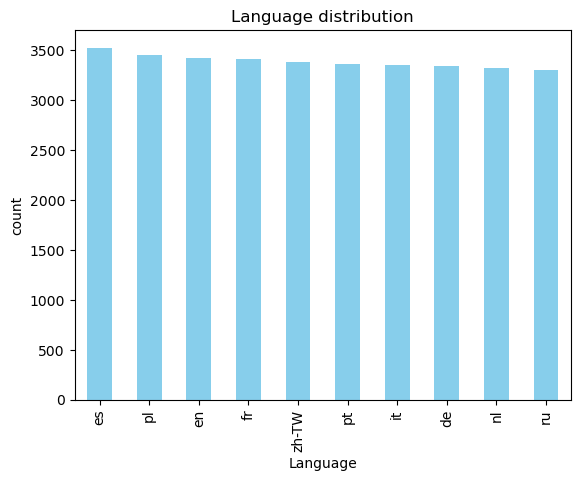

In [8]:
#Exploratory data analysis EDA
data['language_code'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('count')
plt.show()

In [9]:
data.isnull().sum()

text                0
language_code       0
cleaned_text        0
tokens              0
language_encoded    0
dtype: int64

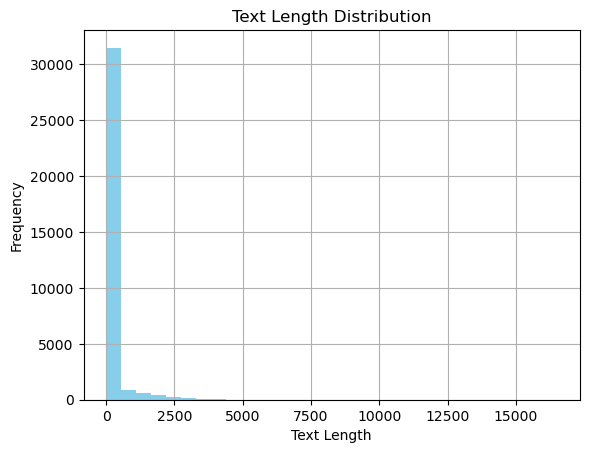

In [10]:
data['text_length'] = data['cleaned_text'].apply(len)  
data['text_length'].hist(color='skyblue', bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

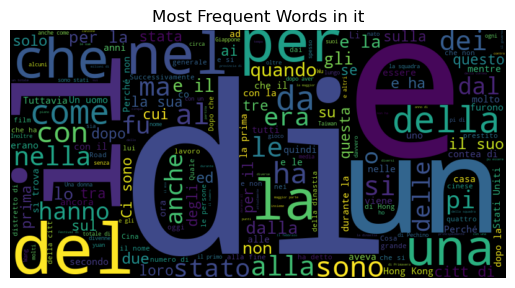

In [27]:
for lang in data['language_code'].unique():  # Loop over each unique language in the 'language' column
    # Filter the data for the current language
    lang_data = data[data['language_code'] == lang]
    wordcloud = WordCloud(width=800, height=400, colormap= 'viridis', background_color=).generate(' '.join(lang_data['cleaned_text']))  # Adjust 'cleaned_text' if your column has a different name
plt.imshow(wordcloud, interpolation='bilinear')  # 'bilinear' interpolation for smoother edges
plt.axis('off')  # Turn off the axis
plt.title(f'Most Frequent Words in {lang}')  # Title with the language name
plt.show()  # Show the wordcloud for the current language